In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

GENERATE_PNGS = True
pd.options.display.float_format = '{:.1f}'.format

In [3]:
results = pd.read_csv('results_concat.csv')
training = results[results.type == 'training']
inference = results[results.type == 'inference']

model_order = {'fcnet': 0, 'scvnet': 1, 'resnet50': 2, 'densenet121': 3, 'mobilenet_v2': 4, 'convnext_small': 5}

In [4]:
train_grouped = training.groupby(['framework', "model_name"]).exec_time.mean()
train_grouped = pd.DataFrame(train_grouped).reset_index()
print('Mean training times [ms] by framework by model')
display(train_grouped.pivot(index='framework', columns='model_name'))

print('Inference times [ms] by framework by model')
inference.pivot(index='framework', columns='model_name', values='exec_time')

Mean training times [ms] by framework by model


exec_time                                                  
model_name convnext_small densenet121   fcnet mobilenet_v2 resnet50  scvnet
framework                                                                  
MATLAB                NaN         NaN 42621.3     433933.3      NaN     NaN
PyTorch          418458.7     95096.9  7012.5      47289.0 144477.5 53857.0
TensorFlow       192714.5     90265.3  3702.2      76482.2 121504.6  5202.9
cuDNN                 NaN         NaN   479.5          NaN      NaN  1837.1

Inference times [ms] by framework by model


model_name,convnext_small,densenet121,fcnet,mobilenet_v2,resnet50,scvnet
framework,,,,,,
MATLAB,NaN,NaN,179.3,2539.0,NaN,NaN
PyTorch,5264.3,4669.2,414.9,1944.2,5200.4,5090.2
TensorFlow,12363.4,3388.4,232.5,2495.8,3704.5,290.0
cuDNN,NaN,NaN,9.5,NaN,NaN,10.3


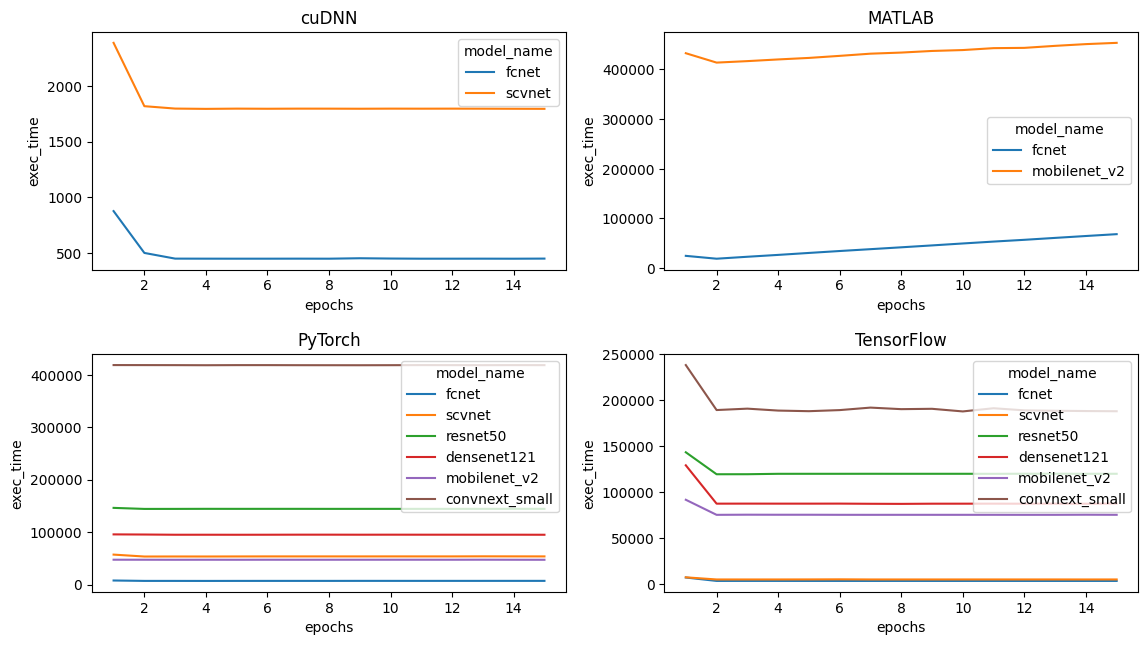

In [5]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(12,7)
fig.tight_layout(pad=4.0)

for ax, framework in zip(axes.flatten(), training.framework.unique()):
	sns.lineplot(data=training[training.framework == framework], x='epochs', y='exec_time', hue='model_name', ax=ax)
	ax.set_title(framework)

if GENERATE_PNGS:
	fig.savefig('./plots/all_frameworks_comparison.png')

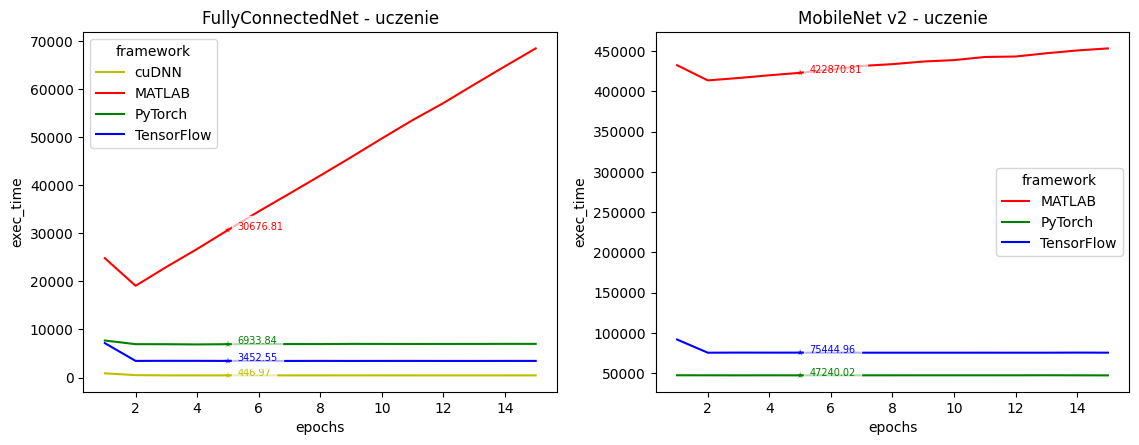

In [6]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.tight_layout(pad=4.0)

def matlab_comparison_plots(ax, model_name, palette, ann_ep, title):
	sns.lineplot(
		data=training[training.model_name == model_name],
		x='epochs', y='exec_time', hue='framework',
		palette=palette, ax=ax
	)

	for y, c in zip(training[(training.model_name == model_name) & (training.epochs == ann_ep)].exec_time, palette):
		ax.text(ann_ep+0.3, y, f'{y:.2f}', color=c, bbox={'color': 'white', 'alpha': 0.7}, fontsize=7)

	sns.scatterplot(
		data=training[(training.model_name == model_name) & (training.epochs == ann_ep)],
		x='epochs', y='exec_time', hue='framework',
		ax=ax, palette=palette,
		legend=False, marker='*'
	)

	ax.set_title(title)

matlab_comparison_plots(axes[0], 'fcnet', ['y', 'r', 'g', 'b'], 5, 'FullyConnectedNet - uczenie')
matlab_comparison_plots(axes[1], 'mobilenet_v2', ['r', 'g', 'b'], 5, 'MobileNet v2 - uczenie')

if GENERATE_PNGS:
	fig.savefig('./plots/matlab_training.png')

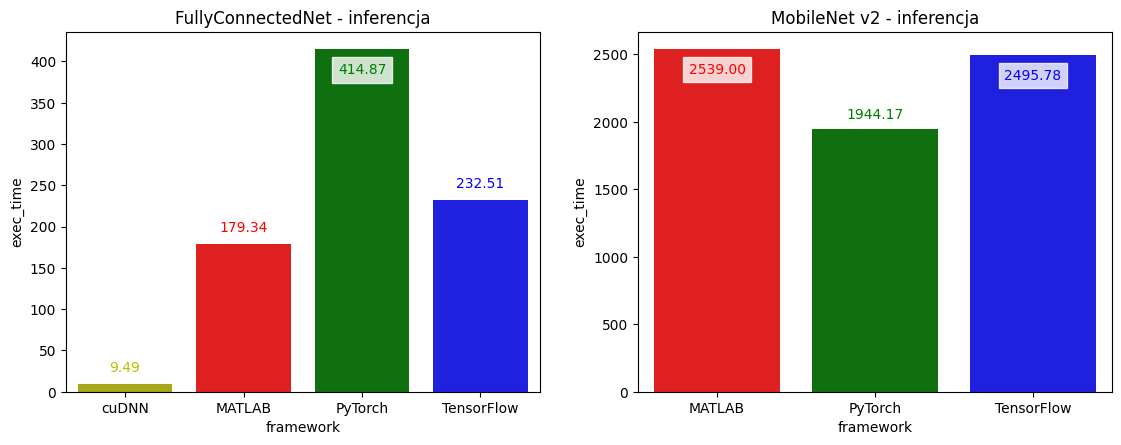

In [7]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.tight_layout(pad=4.0)

sns.barplot(data=inference[inference.model_name == 'fcnet'], x='framework', y='exec_time', ax=axes[0], palette=['y', 'r', 'g', 'b'])
axes[0].set_title('FullyConnectedNet - inferencja')
for x, y, c in zip(range(4), inference[inference.model_name == 'fcnet'].exec_time, ['y', 'r', 'g', 'b']):
	axes[0].text(x=x, y=y+(-30 if x==2 else 15), s=f'{y:.2f}', color=c, bbox={'color': 'white', 'alpha': 0.8}, ha='center')

sns.barplot(data=inference[inference.model_name == 'mobilenet_v2'], x='framework', y='exec_time', ax=axes[1], palette=['r', 'g', 'b'])
axes[1].set_title('MobileNet v2 - inferencja')
for x, y, c in zip(range(3), inference[inference.model_name == 'mobilenet_v2'].exec_time, ['r', 'g', 'b']):
	axes[1].text(x=x, y=y+(80 if x==1 else -180), s=f'{y:.2f}', color=c, bbox={'color': 'white', 'alpha': 0.8}, ha='center')

if GENERATE_PNGS:
	fig.savefig('./plots/matlab_inference.png')

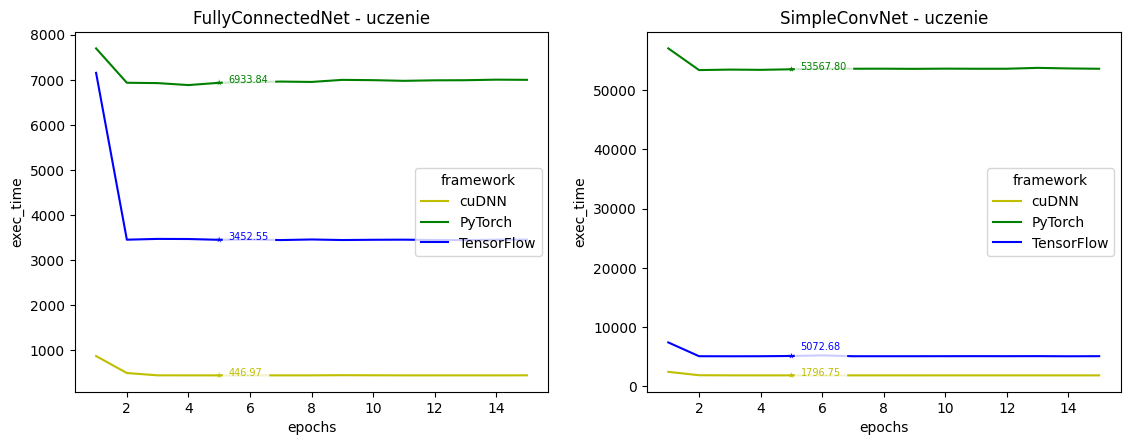

In [8]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.tight_layout(pad=4.0)

def cudnn_comparison_plots(model_name, ax, ann_ep, title):
	sns.lineplot(
		data=training[(training.model_name == model_name) & (training.framework != 'MATLAB')],
		x='epochs', y='exec_time', hue='framework', palette=['y', 'g', 'b'], ax=ax
	)

	sns.move_legend(ax, "center right")
	ax.set_title(title)

	points = training[(training.model_name == model_name) & (training.epochs == ann_ep) & (training.framework != 'MATLAB')]

	for y, c in zip(points.exec_time, ['y', 'g', 'b']):
		ax.text(
			s=f'{y:.2f}', x=ann_ep+0.3, y=y+(1000 if (c == 'b' and model_name == 'scvnet') else 0),
	  	color=c, bbox={'color': 'white', 'alpha': 0.8}, fontsize=7
		)

	sns.scatterplot(data=points, x='epochs', y='exec_time', hue='framework',
		ax=ax, legend=False, marker='*', palette=['y', 'g', 'b']
	)

cudnn_comparison_plots('fcnet', axes[0], 5, 'FullyConnectedNet - uczenie')
cudnn_comparison_plots('scvnet', axes[1], 5, 'SimpleConvNet - uczenie')

if GENERATE_PNGS:
	fig.savefig('./plots/cudnn_training.png')

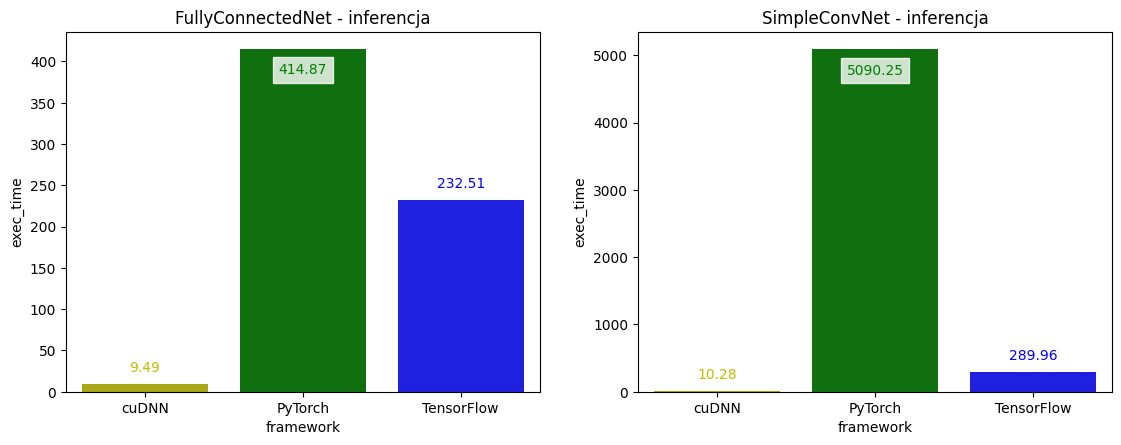

In [14]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.tight_layout(pad=4.0)

sns.barplot(data=inference[(inference.model_name == 'fcnet') & (inference.framework != 'MATLAB')], x='framework', y='exec_time', ax=axes[0], palette=['y', 'g', 'b'])
axes[0].set_title('FullyConnectedNet - inferencja')
for x, y, c in zip(range(3), inference[(inference.model_name == 'fcnet') & (inference.framework != 'MATLAB')].exec_time, ['y', 'g', 'b']):
	axes[0].text(x=x, y=y+(-30 if x==1 else 15), s=f'{y:.2f}', color=c, bbox={'color': 'white', 'alpha': 0.8}, ha='center')

sns.barplot(data=inference[inference.model_name == 'scvnet'], x='framework', y='exec_time', ax=axes[1], palette=['y', 'g', 'b'])
axes[1].set_title('SimpleConvNet - inferencja')
for x, y, c in zip(range(3), inference[inference.model_name == 'scvnet'].exec_time, ['y', 'g', 'b']):
	axes[1].text(x=x, y=y+(-380 if x==1 else 180), s=f'{y:.2f}', color=c, bbox={'color': 'white', 'alpha': 0.8}, ha='center')

if GENERATE_PNGS:
	fig.savefig('./plots/cudnn_inference.png')

In [10]:
modern_models = ['resnet50', 'densenet121', 'mobilenet_v2', 'convnext_small']
py_frameworks = ['PyTorch', 'TensorFlow']
train_mm = training[(training.model_name.isin(modern_models)) & (training.framework.isin(py_frameworks))]
train_mm_agg = pd.DataFrame(train_mm.groupby(by=['framework', 'model_name']).exec_time.mean()).reset_index()
infer_mm = inference[(inference.model_name.isin(modern_models)) & (inference.framework.isin(py_frameworks))]
infer_mm = infer_mm[['framework', 'model_name', 'exec_time']]

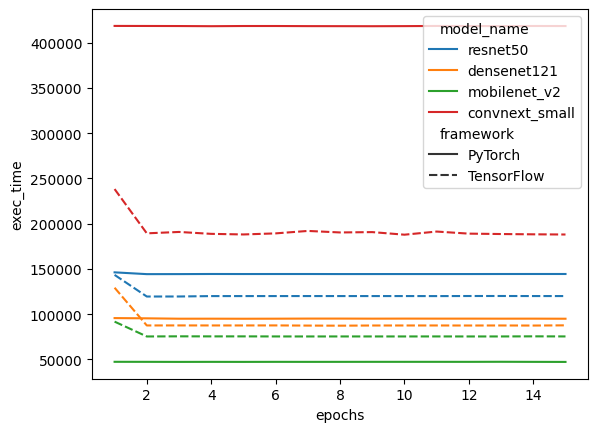

In [11]:
ax = sns.lineplot(data=train_mm, x='epochs', y='exec_time', hue='model_name', style='framework')

if GENERATE_PNGS:
	ax.get_figure().savefig('./plots/py_modern_models_train_lineplot.png')

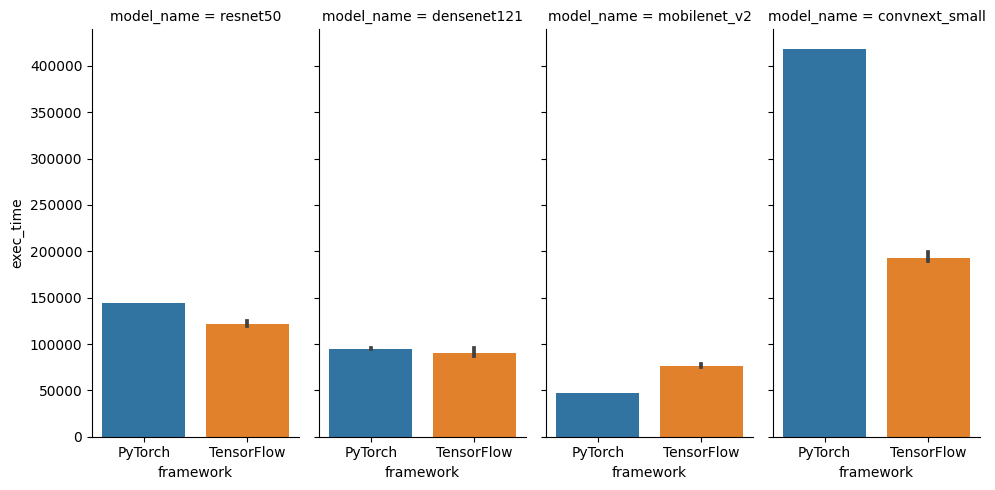

In [12]:
fig = sns.catplot(data=train_mm, x='framework', y='exec_time', col='model_name', kind='bar', aspect=0.5)

if GENERATE_PNGS:
	fig.savefig('./plots/py_modern_models_train_catplot.png')

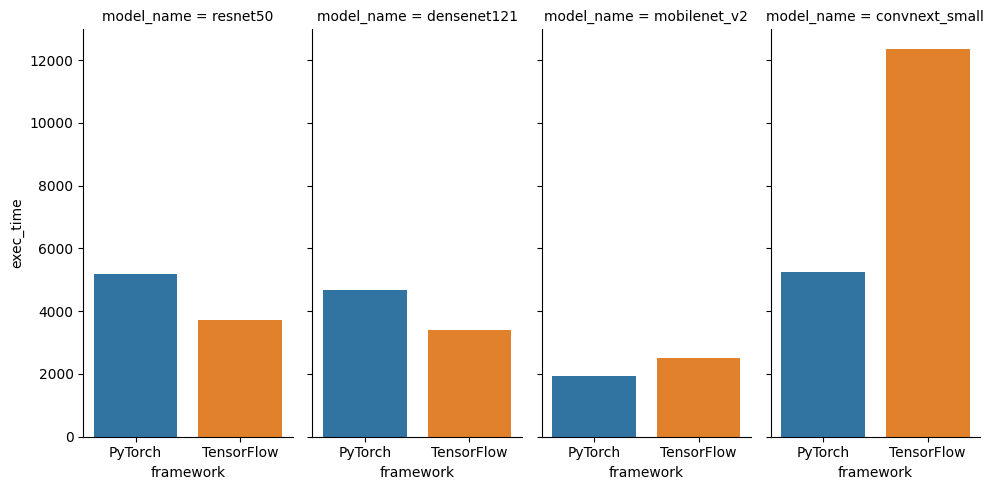

In [13]:
fig = sns.catplot(data=infer_mm, x='framework', y='exec_time', col='model_name', kind='bar', aspect=0.5)

if GENERATE_PNGS:
	fig.savefig('./plots/py_modern_models_infer.png')